# Introduction to the Computation-Thru-Dynamics Benchmark
Hello! Welcome to the Computation-Thru-Dynamics Benchmark! In this tutorial, we'll be walking through the major features of CtD and how you can use it to test the ability of your data-trained models to accurately capture the dynamics of task-trained models. 

Ease them into this a bit more.
More instructions on how to train environment file.
(use relative paths)
Colab / Jupyter server
mkdir (TASK_TRAINED_DATA_HOME, SIMULATED_HOME)


The major features of the CtD Benchmark are summarized in the figure below:

In [ ]:
! pip install -e .

![Easter Egg](png/BenchmarkGrey-01.png)



At a high level, there are 6 main components of the benchmark, each represented by a block on in the flow chart above.

## Use cases:
There are two primary use cases for the code-base:

First, for users that are focused on developing data-trained models, we provide benchmark datasets of simulated neural spiking activity from artificial neural networks trained to perform three tasks of varying complexity. These users can ignore all of the blocks in the grey shaded region and simply use the provided neural datasets and analysis objects to train their data-trained models and compare against.

Second, users might also be interested in how changes in the task-training pipeline might affect the performance of data-trained models, or use the benchmark tools to analyze alternative tasks. These users can use the specifications to build their own tasks and task-training pipelines with ease!

For both users, we have provided a set of metrics and analysis tools in the Analysis and Comparison objects that will allow for easy evaluation of task- and data-trained models. We also provide an analysis object for importing inferred latent activity from data-trained models that are external to the benchmark specifications. Some features (such as Fixed-Point finding) are unavailable for these external data, but others, such as DSA and metrics for reconstruction performance and latent recovery are available.

Basically, we are simulating a brain, and recording it's activity!

![Sims](png/SimulationDiagram.png)

# Analyses and Comparisons in CtD Benchmark
For this tutorial, we are going to start at the end and work backwards.

In the pre-trained models folder, I have saved a "task-trained" and a "data-trained" model. 
- The task-trained model is a 128D GRU-RNN model trained to perform a 3-Bit Flip-Flop task. - "20240207_NBFF_Tutorial"
- The data-trained model is a sequential auto-encoder (SAE) trained to reconstruct simulated spiking activity from the task-trained model. "20240207_NBFF_Tutorial_DataTrained"

We're going to run through the analysis pipeline to see how well the data-trained model captures the latent dynamics of the task-trained model!


In [1]:
from interpretability.comparison.analysis.tt.tt import Analysis_TT
from interpretability.comparison.analysis.dt.dt import Analysis_DT
import dotenv
import os

dotenv.load_dotenv()
HOME_DIR = os.getenv("HOME_DIR")

tt_run = "20240207_NBFF_Tutorial"
dt_run = "20240207_NBFF_Tutorial_DT"

tt_path = HOME_DIR + "benchmark_datasets" + os.sep + "20240207_NBFF_Tutorial" + os.sep + "latent_size=128 max_epochs=1000" + os.sep
dt_path = HOME_DIR + "benchmark_datasets" + os.sep + "20240207_NBFF_Tutorial_DataTrained" + os.sep 

tt = Analysis_TT(run_name= tt_run, filepath = tt_path)
tt_copy = Analysis_TT(run_name = tt_run, filepath = tt_path)
dt = Analysis_DT(run_name = dt_run, filepath = dt_path)



First things first; we need to load the trained models into the "analysis" objects provided as part of the benchmark.
Analysis objects are a multi-level scheme to provide common methods for dealing with both task-trained and data-trained models.

At the top level, Analysis provides methods that are generally required for both task-trained and data-trained models.

At the middle level, Analysis_TT and Analysis_DT implement methods that are specific for each model type. For instance, FP calculation has to be done differently because the model inputs are different. 

At the bottom level, Analysis_{model_type}_{task} implements specific methods for each task type. For instance, Driscoll et al. 2023 implements an input interpolation between tasks in the MultiTask network. Provided in the Analysis_TT_MultiTask object is a method that will perform these analyses for the user.
![Easter Egg](png/AnalysisStructure-01.png)

To demonstrate, let's get plot some fixed-points of our task-trained 3-bit Flip-Flop network.

In [2]:
#tt.plot_fps(q_thresh = 1e-5)

Next, we are going to try to compare our task-trained and data-trained models to see how similar the latent activity is between these two models!

To do this, we're going to use the Comparison object.

![Easter Egg](png/Comparisons-01.png)

The comparisons object takes in two (or more) analysis objects and has a set of built-in functions that perform pairwise comparisons between all of the loaded analyses.

For now, the available comparisons are:
- Rate/State R2
- Dynamical similarity analysis

Lets load our analyses into the comparison object (I will also load a copy of the task-trained analysis to show the pairwise comparisons more clearly)

For the "ground-truth" analysis, we can set the "reference_analysis" equal to True, which is a marker to use that analysis as the target for plotting rotations, etc.

In [3]:
from interpretability.comparison.comparison import Comparison

comp = Comparison()
comp.load_analysis(tt, reference_analysis = True)
comp.load_analysis(tt_copy)
comp.load_analysis(dt)


From here, let's see how similar the inferred latent activity is to the "ground-truth" activity in the task-trained model, starting by plotting a few trials from each model.

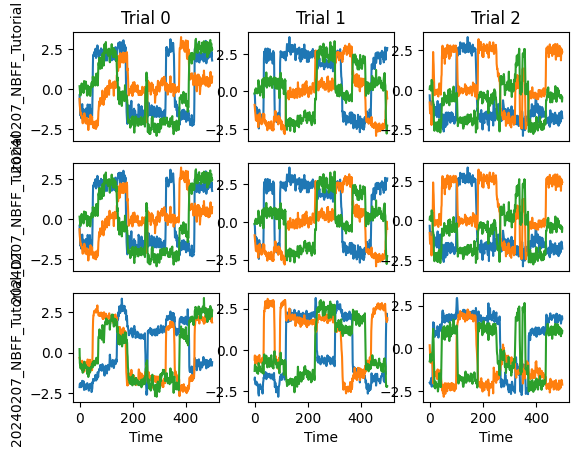

In [4]:
comp.plot_trials(num_trials=3, num_pcs=3)

Unfortunately, it can be pretty difficult to determine how similar these model's latent activity is, so lets allow an affine transformation to align the latents as best as we can.

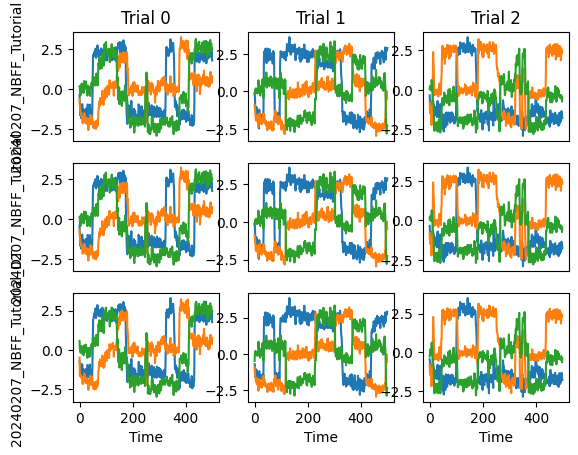

In [5]:
comp.plot_trials_reference(num_trials=3, num_pcs=3)

With the rotated reference, we can see that our data-trained model seems to be recovering the first 3 PCs quite well! This is also evident with the State R2 for the first 3 PCs (which quantifies the goodness-of-fit of the ground truth and inferred latent activities)

array([[1.        , 1.        , 0.97798766],
       [1.        , 1.        , 0.97841798],
       [0.97884592, 0.97847503, 0.99891129]])

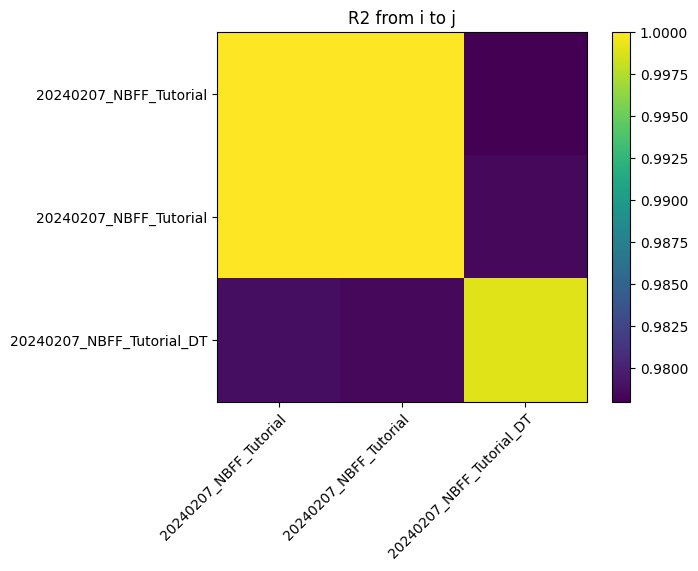

In [6]:
comp.compare_state_r2()

Try the compare_state_r2() function with different numbers of Principal Components. How does the State R2 fare with lower variance PCs?

Because the Analysis objects have standardized methods, we can also import data from models outside of the benchmark using Analysis_External! (TODO)

# Training Data-Trained models on CtD Benchmark Datasets

We've provided a helpful example script to get started with training your own models on the dataset.

In [1]:
import logging
import os
import shutil
from datetime import datetime
from pathlib import Path

import dotenv
import ray
from omegaconf import OmegaConf
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import FIFOScheduler
from ray.tune.search.basic_variant import BasicVariantGenerator

from interpretability.data_modeling.extensions.SAE.utils import make_data_tag
from interpretability.data_modeling.train_neural import train

dotenv.load_dotenv(override=True)
HOME_DIR = Path(os.environ.get("HOME_DIR"))


log = logging.getLogger(__name__)
# ---------------Options---------------
LOCAL_MODE = False
OVERWRITE = True
WANDB_LOGGING = True

RUN_DESC = "NBFF_Comparison"
NUM_SAMPLES = 1
MODEL_CLASS = "SAE"
MODEL = "GRU_RNN"
DATA = "NBFF"
INFER_INPUTS = False

# -------------------------------------
SEARCH_SPACE = dict(
    model=dict(
        latent_size=tune.grid_search([128]),
    ),
    datamodule=dict(
        gen_model=tune.grid_search(["GRU_RNN"]),
        # Change the prefix to the correct path for your task-trained network
        prefix=tune.grid_search(["20240207_NBFF_Tutorial"]),
    ),
    params=dict(
        seed=tune.grid_search([0]),
    ),
)

# -----------------Default Parameter Sets -----------------------------------
cpath = "../data_modeling/configs"

model_path = Path(
    (
        f"{cpath}/models/{MODEL_CLASS}/{DATA}/{DATA}_{MODEL}"
        f"{'_infer' if INFER_INPUTS else ''}.yaml"
    )
)
datamodule_path = Path(
    (
        f"{cpath}/datamodules/{MODEL_CLASS}/data_{DATA}"
        f"{'_infer' if INFER_INPUTS else ''}.yaml"
    )
)

callbacks_path = Path(f"{cpath}/callbacks/{MODEL_CLASS}/default_{DATA}.yaml")
loggers_path = Path(f"{cpath}/loggers/{MODEL_CLASS}/default.yaml")
trainer_path = Path(f"{cpath}/trainers/trainer_{DATA}.yaml")

if not WANDB_LOGGING:
    loggers_path = Path(f"{cpath}/loggers/{MODEL_CLASS}/default_no_wandb.yaml")
    callbacks_path = Path(f"{cpath}/callbacks/{MODEL_CLASS}/default_no_wandb.yaml")
config_dict = dict(
    model=model_path,
    datamodule=datamodule_path,
    callbacks=callbacks_path,
    loggers=loggers_path,
    trainer=trainer_path,
)

# ------------------Data Management Variables --------------------------------
DATE_STR = datetime.now().strftime("%Y%m%d")
RUN_TAG = f"{DATE_STR}_{RUN_DESC}"
RUNS_HOME = Path(HOME_DIR)
RUN_DIR =  HOME_DIR / "runs" / "data-trained" / RUN_TAG
path_dict = dict(
    tt_datasets=HOME_DIR / "datasets" / "tt",
    dt_datasets=HOME_DIR / "datasets" / "dt",
    trained_models=HOME_DIR / "trained_models",
)

def trial_function(trial):
    return trial.experiment_tag


# -------------------Main Function----------------------------------
def main(
    run_tag_in: str,
    path_dict: dict,
    config_dict: dict,
):
    if LOCAL_MODE:
        ray.init(local_mode=True)
    if RUN_DIR.exists() and OVERWRITE:
        shutil.rmtree(RUN_DIR)

    RUN_DIR.mkdir(parents=True)
    run_dir = str(RUN_DIR)
    tune.run(
        tune.with_parameters(
            train,
            run_tag=run_tag_in,
            config_dict=config_dict,
            path_dict= path_dict
        ),
        config=SEARCH_SPACE,
        resources_per_trial=dict(cpu=10, gpu=1),
        num_samples=NUM_SAMPLES,
        local_dir=run_dir,
        search_alg=BasicVariantGenerator(),
        scheduler=FIFOScheduler(),
        verbose=1,
        progress_reporter=CLIReporter(
            metric_columns=["loss", "training_iteration"],
            sort_by_metric=True,
        ),
        trial_dirname_creator=trial_function,
    )


if __name__ == "__main__":
    # main(
    #     run_tag_in=RUN_TAG,
    #     config_dict=config_dict,
    #     path_dict=path_dict,
    # )
    pass


# Task-environments

Let's zoom in on each of these components briefly to see what they are, starting with the task environments:

![Easter Egg](png/TaskEnvs-01.png)


We have provided three task environments on which the user can fit their models. 

1. N-Bit Flip-Flop: An extension of the standard "Three-Bit Flip-Flop" task described by Sussillo et al. 2012. This task takes in a parameter for the number of "switches" to include. The default, and the provided spiking dataset is with N=3.

2. Multi-Task: A PyTorch implementation of the MultiTask network described in Yang et al. and extended in Driscoll et al. 2022. This environment encompasses 15 tasks, including memory, context dependent decisionmaking, and category matching. Previous experiments have found that networks trained on this task learn "dynamical motifs" that are shared between networks.

3. Delayed Random Target Reaching: A environment build using MotorNet (Codol et al. 2023), a musculoskeletal modeling suite that makes it easy to train task-trained models to perform motor tasks. This task uses a 6-muscle, two-joint arm model to perform planar reaching to targets. The model is shown a target, and after a delay period, instructed to reach to the target to minimize the loss.

I replicate the Three-Bit Flip-Flop code below for visibility, but see interpretability.task_modeling.task_env.task_env for the original code.

In [ ]:
from interpretability.task_modeling.task_env.task_env import DecoupledEnvironment
# Class to generate training data for task-trained RNN that does 3 bit memory task

import matplotlib.pyplot as plt
import numpy as np
from gymnasium import spaces

class NBitFlipFlop(DecoupledEnvironment):
    """
    An environment for an N-bit flip flop.
    This is a simple toy environment where the goal is to flip the required bit.
    """

    def __init__(self, n_timesteps: int, noise: float, n=1, switch_prob=0.01):
        super().__init__(n_timesteps=n_timesteps, noise=noise)
        self.dataset_name = f"{n}BFF"
        self.action_space = spaces.Box(low=-0.5, high=1.5, shape=(n,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-1.5, high=1.5, shape=(n,), dtype=np.float32
        )
        self.context_inputs = spaces.Box(
            low=-1.5, high=1.5, shape=(0,), dtype=np.float32
        )
        self.n = n
        self.state = np.zeros(n)
        self.input_labels = [f"Input {i}" for i in range(n)]
        self.output_labels = [f"Output {i}" for i in range(n)]
        self.noise = noise
        self.coupled_env = False
        self.switch_prob = switch_prob

    def step(self, action):
        # Generates state update given an input to the flip-flop
        for i in range(self.n):
            if action[i] == 1:
                self.state[i] = 1
            elif action[i] == -1:
                self.state[i] = 0

    def generate_trial(self):
        # Make one trial of flip-flop
        self.reset()

        # Generate the times when the bit should flip
        inputRand = np.random.random(size=(self.n_timesteps, self.n))
        inputs = np.zeros((self.n_timesteps, self.n))
        inputs[
            inputRand > (1 - self.switch_prob)
        ] = 1  # 2% chance of flipping up or down
        inputs[inputRand < (self.switch_prob)] = -1

        # Set the first 3 inputs to 0 to make sure no inputs come in immediately
        inputs[0:3, :] = 0

        # Generate the desired outputs given the inputs
        outputs = np.zeros((self.n_timesteps, self.n))
        for i in range(self.n_timesteps):
            self.step(inputs[i, :])
            outputs[i, :] = self.state

        # Add noise to the inputs for the trial
        true_inputs = inputs
        inputs = inputs + np.random.normal(loc=0.0, scale=self.noise, size=inputs.shape)
        return inputs, outputs, true_inputs

    def reset(self):
        self.state = np.zeros(self.n)
        return self.state

    def generate_dataset(self, n_samples):
        # Generates a dataset for the NBFF task
        n_timesteps = self.n_timesteps
        ics_ds = np.zeros(shape=(n_samples, self.n))
        outputs_ds = np.zeros(shape=(n_samples, n_timesteps, self.n))
        inputs_ds = np.zeros(shape=(n_samples, n_timesteps, self.n))
        true_inputs_ds = np.zeros(shape=(n_samples, n_timesteps, self.n))
        for i in range(n_samples):
            inputs, outputs, true_inputs = self.generate_trial()
            outputs_ds[i, :, :] = outputs
            inputs_ds[i, :, :] = inputs
            true_inputs_ds[i, :, :] = true_inputs

        dataset_dict = {
            "ics": ics_ds,
            "inputs": inputs_ds,
            "targets": outputs_ds,
            "true_inputs": true_inputs_ds,
            "conds": np.zeros(shape=(n_samples, 1)),
            # No extra info for this task, so just fill with zeros
            "extra": np.zeros(shape=(n_samples, 1)),
        }
        return dataset_dict

    def render(self):
        inputs, states, _ = self.generate_trial()
        fig1, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
        ax1 = axes[0]
        ax1.plot(states)
        ax1.set_ylabel("Flip-flop state")
        ax2 = axes[1]
        ax2.plot(inputs)
        ax2.set_xlabel("Time")
        ax2.set_ylabel("Inputs")
        plt.savefig("sampleTrial.png", dpi=300)

The major function needed by all task_envs is the "generate_dataset" function. This function returns a dictionary with the following fields, with B, T, N indicating the number of samples, # timesteps, and state dimensionality, respectively:

ics - BxTxN Tensor: The initial conditions of each trial. For NBFF, the system will always start with a state of zeros in all of its bits.

inputs - BxTxN Tensor: The simulated inputs for each trial. There is a 1% chance each for a positive or negative input on each channel during each timestep. There is also independent Gaussian noise added to each channel.

targets - BxTxN Tensor: The desired outputs of the NBFF given the set of inputs. In this case, it is the state of the flip-flop

conds - Bx1 Tensor: For task_envs in which there are obvious conditions that may need to be treated differently during training (for example, the task in MultiTask). For NBFF, there are no relevant conditions.

extra -  BxTx1 Tensor: For task_envs in which there is additional information which is needed for the loss function or to make additional processing easier. For instance, in MultiTask the trial lengths vary across trials, so it is necessary to include the length of each trial


Let's use the "render" function to see what a single trial looks like!

In [ ]:
nbff = NBitFlipFlop(n_timesteps=100, noise=0.1, n=3)
nbff.render()

The other task_envs have more complex task-logic, but the essence is the same. The only function that is required to interface with the benchmark is the "generate_dataset" function, which should return a dict with the fields seen above.

Now that we've reviewed the task-env, lets look at the process of training a task-trained model.

![Easter Egg](png/TaskTrained-01.png)

Task training is performed by a wrapper located at interpretability.task_modeling.task_wrapper.task_wrapper.py

This code-base uses PyTorch Lightning to handle a lot of the code engineering and simplify the process for the user to get up and running. For that reason, you shouldn't have to change any aspect of the task_wrapper code to train your models. The script to start task-training is in the examples/run_task_training.py, but I've copied it here to walk through what each section does.

But first, you'll need to do a couple of housekeeping items:

1. Log into WandB (if you want to log your runs)
2. Change the paths in .env to point to the preferred locations in your directory.

![Code](png/TaskCode.png)


In [ ]:
import logging
import os
import shutil
from datetime import datetime
from pathlib import Path

import dotenv
import ray
from omegaconf import OmegaConf
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import FIFOScheduler
from ray.tune.search.basic_variant import BasicVariantGenerator

from interpretability.task_modeling.task_train_prep import train
from utils import make_data_tag, trial_function

dotenv.load_dotenv()
RUNS_HOME = os.environ.get("RUNS_HOME")
TRAINED_MODEL_PATH = os.environ.get("TRAINED_MODEL_PATH")
# Add custom resolver to create the data_tag so it can be used for run dir
OmegaConf.register_new_resolver("make_data_tag", make_data_tag, replace=True)
log = logging.getLogger(__name__)

# ---------------Options---------------
LOCAL_MODE = False  # Set to True to run locally (for debugging)
OVERWRITE = True  # Set to True to overwrite existing run
WANDB_LOGGING = True  # Set to True to log to WandB (need an account)

RUN_DESC = "NBFF_Tutorial_LabMeeting"  # For WandB and run dir
TASK = "NBFF"  # Task to train on (see configs/task_env for options)
MODEL = "GRU_RNN"  # Model to train (see configs/model for options)

# -----------------Parameter Selection -----------------------------------
SEARCH_SPACE = dict(
    # Model Parameters -----------------------------------
    model=dict(
        latent_size=tune.grid_search([64]),
    ),
    # datamodule=dict(
    #     # Data Parameters -----------------------------------
    #     n_samples=tune.choice([1000]),
    #     batch_size=tune.choice([512]),
    # ),
    trainer=dict(
        # Trainer Parameters -----------------------------------
        max_epochs=tune.choice([100]),
    ),
    # Data Parameters -----------------------------------
    # params=dict(
    #     seed=tune.grid_search([0]),
    # ),
)


# ------------------Data Management Variables --------------------------------
DATE_STR = datetime.now().strftime("%Y%m%d")
RUN_TAG = f"{DATE_STR}_{RUN_DESC}"
RUNS_HOME = Path(RUNS_HOME)
SAVE_PATH = TRAINED_MODEL_PATH + "task-trained/"
RUN_DIR = RUNS_HOME / "task-trained" / RUN_TAG
# -----------------Default Parameter Sets -----------------------------------
path_dict = dict(
    task_wrapper=Path(f"configs/task_wrapper/{TASK}.yaml"),
    task_env=Path(f"configs/task_env/{TASK}.yaml"),
    model=Path(f"configs/model/{MODEL}.yaml"),
    datamodule=Path(f"configs/datamodule/datamodule_{TASK}.yaml"),
    simulator=Path(f"configs/simulator/default_{TASK}.yaml"),
    callbacks=Path(f"configs/callbacks/default_{TASK}.yaml"),
    loggers=Path("configs/logger/default.yaml"),
    trainer=Path("configs/trainer/default.yaml"),
)

if not WANDB_LOGGING:
    path_dict["loggers"] = Path("configs/logger/default_no_wandb.yaml")
    path_dict["callbacks"] = Path("configs/callbacks/default_no_wandb.yaml")


# -------------------Main Function----------------------------------
def main(
    run_tag_in: str,
    save_path_in: str,
    path_dict: dict,
):
    if LOCAL_MODE:
        ray.init(local_mode=True)
    if RUN_DIR.exists() and OVERWRITE:
        shutil.rmtree(RUN_DIR)

    RUN_DIR.mkdir(parents=True)
    # shutil.copyfile(__file__, RUN_DIR / Path(__file__).name)
    tune.run(
        tune.with_parameters(
            train,
            run_tag=run_tag_in,
            save_path=save_path_in,
            path_dict=path_dict,
        ),
        metric="loss",
        mode="min",
        config=SEARCH_SPACE,
        resources_per_trial=dict(cpu=8, gpu=0.9),
        num_samples=1,
        storage_path=str(RUN_DIR),
        search_alg=BasicVariantGenerator(),
        scheduler=FIFOScheduler(),
        verbose=1,
        progress_reporter=CLIReporter(
            metric_columns=["loss", "training_iteration"],
            sort_by_metric=True,
        ),
        trial_dirname_creator=trial_function,
    )


if __name__ == "__main__":
    main(
        run_tag_in=RUN_TAG,
        save_path_in=SAVE_PATH,
        path_dict=path_dict,
    )


Running this code will train a task-trained GRU to perform 3BFF for 100 epochs, which on a GPU should take less than 5 minutes. Going to WandB, we can see with some provided callbacks how the model training is progressing.

These variables:

    RUN_DESC = "NBFF_Tutorial"  # For WandB and run dir
    TASK = "NBFF"  # Task to train on (see configs/task_env for options)
    MODEL = "GRU_RNN"  # Model to train (see configs/model for options)

define the task and model that we want to run, as well as the default hyperparameters. Ray-Tune allows for hyperparameter sweeps to be performed easily using tune.grid_search, or tune.choice/tune.randomuniform, etc.

Changing parameters in the search space will override the default parameters in the configuration files, allowing users to quickly test the effects of changing environment parameters and models.


![NBFFGRUg](png/NBFFGRU.png)
![LatentActivity](png/NBFF_Lats.png)
![States](png/NBFF_States.png)


Obviously, the model isn't done training yet, because the performance doesn't look great. But increasing the # of epochs will make it train well.